In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed,MaxPooling2D
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
#n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=144 #區間為12小時
currency = ["SEK","CHF","CAD","GBP","JPY","EUR","AUD","SGD","HKD","NZD"]
#SEK:瑞典克朗  CHF:瑞士法郎 CAD:加拿大幣 GBP:英鎊 
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5802,11745,18351,24380,30579,36861,42795,49201,55342,61230,67400,73732,79984,85726,92343,98127,104692,111028,117076,123700,129807,136083,142401,148335]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0
head = 12
tail = 17
epochs = 65
batch_size = 4096
#pl 4  kn 5
pl=8
kn=9
all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
train_length=3 
test_length=1 

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)


In [6]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2,typeq):
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    outcome[6]=(data2_sum[6])
    outcome[7]=(data2_sum[7])
    outcome[8]=(data2_sum[8])
    outcome[9]=(data2_sum[9])    
    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    outcome[6]=data2_std[6]     
    outcome[7]=data2_std[7]
    outcome[8]=data2_std[8]     
    outcome[9]=data2_std[9] 
    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)


In [7]:
"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print(v.shape)
    v = v.reshape(len(v),currencynum,l,1)
    print(v.shape)
    print("[Training model......]")
    
    #Train_v=v[:]
    
    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a,validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    print("Reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:12]
    Test_q_reverse[:,2:12]=Test_q_reverse[:,12:22]
    Test_q_reverse[:,12:22]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])

    """
    分開兩種問題的test集_reverse
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==90):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==90):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率_reverse
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
        
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)
    plt.show()    
def ConvolutionNetworks(fn,ks):
    def conv(model):
        for i in range(len(fn)):
            model = (Conv2D(filters=fn[i],kernel_size=ks[i],padding='valid',activation='relu'))(model)  
            model = (MaxPooling2D(pool_size=(1,pl)))(model)
            model = BatchNormalization()(model)
        return model
    return conv



def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y


def build_tag(conv):
    d = K.int_shape(conv)[1]
    d2 = K.int_shape(conv)[2]
    tag = np.zeros((d,d2,d+1))
    for i in range(d):
        for j in range(d2):
            tag[i,j,d] = float(int(i%d))/(d-1)*2-1
            tag[i,j,i] = 1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

(148335, 1)
finish dataread
(None, 10, 1, 10)
(None, 10, 1, 11)
(None, 10, 1, 21)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=23.3 GiB, count=2, average=11.6 GiB
(2169630, 144, 10)
(2169630, 10, 144, 1)
[Training model......]
Train on 1649070 samples, validate on 494640 samples
Epoch 1/65
1649070/1649070 [==============================] - 83s 50us/step - loss: 1.3363 - acc: 0.5098 - val_loss: 0.6752 - val_acc: 0.5906
Epoch 2/65
1649070/1649070 [==============================] - 51s 31us/step - loss: 0.6994 - acc: 0.5569 - val_loss: 0.6514 - val_acc: 0.6133
Epoch 3/65
1649070/1649070 [==============================] - 49s 30us/step - loss: 0.6595 - acc: 0.5834 - val_loss: 0.6386 - val_acc: 0.6189
Epoch 4/65
1649070/1649070 [==============================] - 51s 31us/step - loss: 0.6433 - acc: 0.5970 - val_loss: 0.6297 - val_acc: 0.6211
Epoch 5/65
1649070/1649070 [==============================] - 49s 30us/step - l

Epoch 56/65
1649070/1649070 [==============================] - 51s 31us/step - loss: 0.5740 - acc: 0.6437 - val_loss: 0.6108 - val_acc: 0.6142
Epoch 57/65
1649070/1649070 [==============================] - 49s 30us/step - loss: 0.5732 - acc: 0.6444 - val_loss: 0.6117 - val_acc: 0.6143
Epoch 58/65
1649070/1649070 [==============================] - 51s 31us/step - loss: 0.5723 - acc: 0.6442 - val_loss: 0.6122 - val_acc: 0.6136
Epoch 59/65
1649070/1649070 [==============================] - 49s 30us/step - loss: 0.5713 - acc: 0.6454 - val_loss: 0.6127 - val_acc: 0.6124
Epoch 60/65
1649070/1649070 [==============================] - 51s 31us/step - loss: 0.5706 - acc: 0.6456 - val_loss: 0.6131 - val_acc: 0.6133
Epoch 61/65
1649070/1649070 [==============================] - 49s 30us/step - loss: 0.5695 - acc: 0.6461 - val_loss: 0.6137 - val_acc: 0.6130
Epoch 62/65
1649070/1649070 [==============================] - 51s 31us/step - loss: 0.5688 - acc: 0.6472 - val_loss: 0.6142 - val_acc: 0.6132

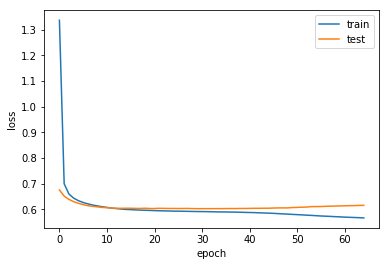

(148335, 1)
finish dataread
(None, 10, 1, 10)
(None, 10, 1, 11)
(None, 10, 1, 21)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=23.6 GiB, count=283, average=85.3 MiB
(2197800, 144, 10)
(2197800, 10, 144, 1)
[Training model......]
Train on 1606950 samples, validate on 564930 samples
Epoch 1/65
1606950/1606950 [==============================] - 81s 50us/step - loss: 1.3708 - acc: 0.5118 - val_loss: 0.6704 - val_acc: 0.5828
Epoch 2/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.7204 - acc: 0.5433 - val_loss: 0.6587 - val_acc: 0.6063
Epoch 3/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.6681 - acc: 0.5748 - val_loss: 0.6458 - val_acc: 0.6170
Epoch 4/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.6456 - acc: 0.5974 - val_loss: 0.6326 - val_acc: 0.6238
Epoch 5/65
1606950/1606950 [==============================] - 48s 30us/step -

Epoch 56/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.5634 - acc: 0.6500 - val_loss: 0.6268 - val_acc: 0.6272
Epoch 57/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.5631 - acc: 0.6504 - val_loss: 0.6284 - val_acc: 0.6283
Epoch 58/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.5625 - acc: 0.6506 - val_loss: 0.6274 - val_acc: 0.6166
Epoch 59/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.5620 - acc: 0.6517 - val_loss: 0.6275 - val_acc: 0.6154
Epoch 60/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.5615 - acc: 0.6521 - val_loss: 0.6284 - val_acc: 0.6157
Epoch 61/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.5611 - acc: 0.6522 - val_loss: 0.6303 - val_acc: 0.6145
Epoch 62/65
1606950/1606950 [==============================] - 48s 30us/step - loss: 0.5605 - acc: 0.6526 - val_loss: 0.6284 - val_acc: 0.6145

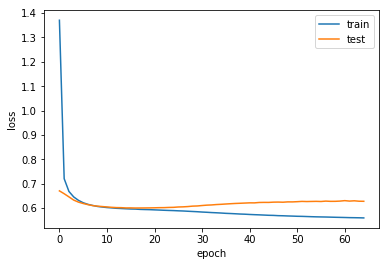

(148335, 1)
finish dataread
(None, 10, 1, 10)
(None, 10, 1, 11)
(None, 10, 1, 21)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=24.2 GiB, count=285, average=86.8 MiB
(2251260, 144, 10)
(2251260, 10, 144, 1)
[Training model......]
Train on 1681020 samples, validate on 544320 samples
Epoch 1/65
1681020/1681020 [==============================] - 83s 49us/step - loss: 0.9806 - acc: 0.5210 - val_loss: 0.6711 - val_acc: 0.6002
Epoch 2/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.6905 - acc: 0.5657 - val_loss: 0.6412 - val_acc: 0.6224
Epoch 3/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.6466 - acc: 0.6058 - val_loss: 0.6198 - val_acc: 0.6196
Epoch 4/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.6263 - acc: 0.6204 - val_loss: 0.6113 - val_acc: 0.6198
Epoch 5/65
1681020/1681020 [==============================] - 48s 28us/step -

Epoch 56/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.5799 - acc: 0.6443 - val_loss: 0.5997 - val_acc: 0.6253
Epoch 57/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.5794 - acc: 0.6440 - val_loss: 0.6002 - val_acc: 0.6253
Epoch 58/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.5788 - acc: 0.6450 - val_loss: 0.6008 - val_acc: 0.6254
Epoch 59/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.5783 - acc: 0.6452 - val_loss: 0.6009 - val_acc: 0.6256
Epoch 60/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.5776 - acc: 0.6450 - val_loss: 0.6013 - val_acc: 0.6250
Epoch 61/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.5770 - acc: 0.6453 - val_loss: 0.6022 - val_acc: 0.6251
Epoch 62/65
1681020/1681020 [==============================] - 48s 28us/step - loss: 0.5762 - acc: 0.6463 - val_loss: 0.6020 - val_acc: 0.6247

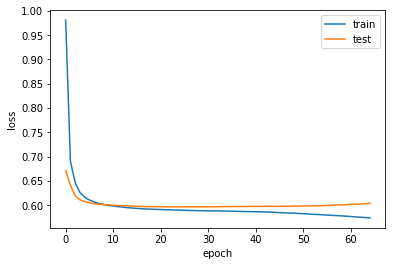

(148335, 1)
finish dataread
(None, 10, 1, 10)
(None, 10, 1, 11)
(None, 10, 1, 21)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=23.6 GiB, count=286, average=84.5 MiB
(2200050, 144, 10)
(2200050, 10, 144, 1)
[Training model......]
Train on 1655730 samples, validate on 518400 samples
Epoch 1/65
1655730/1655730 [==============================] - 85s 51us/step - loss: 2.2597 - acc: 0.5136 - val_loss: 0.7162 - val_acc: 0.5587
Epoch 2/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.7430 - acc: 0.5531 - val_loss: 0.6643 - val_acc: 0.6123
Epoch 3/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.6697 - acc: 0.5849 - val_loss: 0.6389 - val_acc: 0.6182
Epoch 4/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.6462 - acc: 0.6046 - val_loss: 0.6256 - val_acc: 0.6216
Epoch 5/65
1655730/1655730 [==============================] - 46s 28us/step -

Epoch 56/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.5836 - acc: 0.6425 - val_loss: 0.6043 - val_acc: 0.6241
Epoch 57/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.5832 - acc: 0.6431 - val_loss: 0.6048 - val_acc: 0.6253
Epoch 58/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.5827 - acc: 0.6437 - val_loss: 0.6049 - val_acc: 0.6246
Epoch 59/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.5823 - acc: 0.6435 - val_loss: 0.6049 - val_acc: 0.6236
Epoch 60/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.5818 - acc: 0.6433 - val_loss: 0.6056 - val_acc: 0.6235
Epoch 61/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.5811 - acc: 0.6439 - val_loss: 0.6057 - val_acc: 0.6235
Epoch 62/65
1655730/1655730 [==============================] - 46s 28us/step - loss: 0.5808 - acc: 0.6440 - val_loss: 0.6062 - val_acc: 0.6232

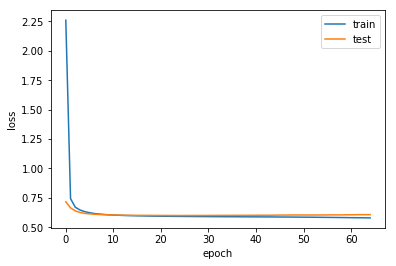

(148335, 1)
finish dataread
(None, 10, 1, 10)
(None, 10, 1, 11)
(None, 10, 1, 21)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=24.4 GiB, count=286, average=87.4 MiB
(2275650, 144, 10)
(2275650, 10, 144, 1)
[Training model......]
Train on 1679490 samples, validate on 570240 samples
Epoch 1/65
1679490/1679490 [==============================] - 88s 53us/step - loss: 1.8006 - acc: 0.5086 - val_loss: 0.6760 - val_acc: 0.5922
Epoch 2/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.7381 - acc: 0.5528 - val_loss: 0.6481 - val_acc: 0.6084
Epoch 3/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.6667 - acc: 0.5904 - val_loss: 0.6306 - val_acc: 0.6155
Epoch 4/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.6409 - acc: 0.6083 - val_loss: 0.6211 - val_acc: 0.6176
Epoch 5/65
1679490/1679490 [==============================] - 47s 28us/step -

Epoch 56/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.5844 - acc: 0.6417 - val_loss: 0.5997 - val_acc: 0.6221
Epoch 57/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.5840 - acc: 0.6418 - val_loss: 0.5999 - val_acc: 0.6213
Epoch 58/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.5835 - acc: 0.6419 - val_loss: 0.6005 - val_acc: 0.6212
Epoch 59/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.5829 - acc: 0.6423 - val_loss: 0.6005 - val_acc: 0.6213
Epoch 60/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.5824 - acc: 0.6426 - val_loss: 0.6009 - val_acc: 0.6205
Epoch 61/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.5819 - acc: 0.6426 - val_loss: 0.6013 - val_acc: 0.6207
Epoch 62/65
1679490/1679490 [==============================] - 47s 28us/step - loss: 0.5813 - acc: 0.6432 - val_loss: 0.6011 - val_acc: 0.6207

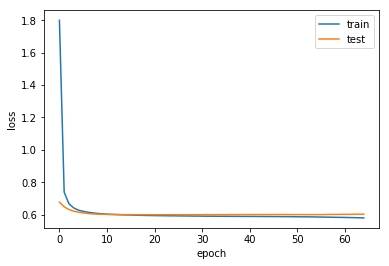

In [8]:
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SEK_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sek5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sek5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SGD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sgd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sgd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/NZD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    nzd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        nzd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=sek5months[p:p+l]
        Train_data[p,1,:]=chf5months[p:p+l]
        Train_data[p,2,:]=cad5months[p:p+l]
        Train_data[p,3,:]=gbp5months[p:p+l]
        Train_data[p,4,:]=jpy5months[p:p+l]
        Train_data[p,5,:]=eur5months[p:p+l]
        Train_data[p,6,:]=aud5months[p:p+l]  
        Train_data[p,7,:]=sgd5months[p:p+l]
        Train_data[p,8,:]=hkd5months[p:p+l]
        Train_data[p,9,:]=nzd5months[p:p+l] 
    MLP_unit=64
    visual_scene = Input((currencynum,l,1))
    visual_conv = ConvolutionNetworks([20,10],[(1,kn),(1,kn)])(visual_scene)
    print(K.int_shape(visual_conv))
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([tag, visual_conv])
    print(K.int_shape(visual_conv))
    
    shapes = visual_conv.shape
    w = shapes[1]
    f = shapes[2]
    features= []
    #features = np.zeros(0)
    for k1 in range(w):
        for k2 in range(f):
            def get_feature(t):
                return t[:, k1, k2, :]
            #get_feature_layer = Lambda(get_feature)
            features.append(Lambda(get_feature)(visual_conv))
    
      
    input2 = Input((22,))
    onehot_encode_question = input2
    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode_question]))    
    
     
    g_MLP = get_MLP(4, get_dense(4,MLP_unit))
    
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))
    
    combined_relation = Add()(mid_relations)
    
    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')
    
    pred = Dense(1, activation = 'sigmoid')(rn)
    
    
    #model = Model(inputs=[visual_scene])
    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

train_acc:red,test_acc:blue


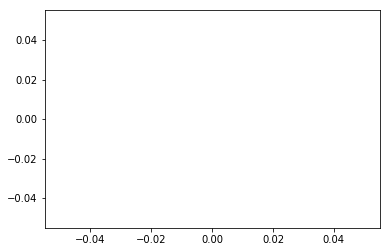

train_loss:red,test_loss:blue


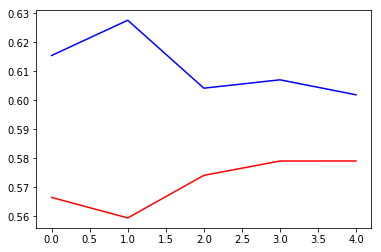

trend:red,vol:blue


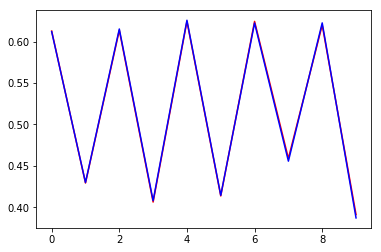

In [9]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()


In [ ]:
model.summary()

In [ ]:
K.clear_session()